# QCSubmit Protein Fragments TorsionDrive preparation

In [1]:
import os

from qcsubmit.factories import TorsiondriveDatasetFactory
from openforcefield.topology import Molecule
from openforcefield.utils.toolkits import RDKitToolkitWrapper, UndefinedStereochemistryError

We'll use the same artifacts produced for submitting Optimizations in "2020-08-12-OpenFF-Protein-Fragments-version2".

In [2]:
!tar -xzf ../2020-08-12-OpenFF-Protein-Fragments-version2/Input_files.tar.gz -C .

Need to:
- [x] generate dihedral atoms for each molecule that we want to torsiondrive
- [x] prepare README
- [x] prepare `dataset.json`

## Prototyping from a single molecule

We'll use this function, modified a bit from the Optimization version of this same dataset:

In [3]:
def build_molecule(folder):
    """
    Create a molecule from all of the conformers in the folder.
    """
    molecules = []
    for file in os.listdir(folder):
        if file.endswith(".mol2") and not file.startswith('.'):
            # this is one of the molecules
            try:
                mol2 = Molecule.from_file(os.path.join(folder, file))
            except UndefinedStereochemistryError:
                # if we get undefined stereochemistry, we skip this conformer
                print(f"Undefined stereochemistry for {folder}/{file}; skipping")
                continue
            # now save again in PDB format
            name = file.split(".")[0]
            # fix issue with openeye reordering when writing files.
            mol2.to_file(os.path.join(folder, name + ".pdb"), "pdb", RDKitToolkitWrapper())
            # load up the new molecule
            pdb = Molecule.from_file(os.path.join(folder, name + ".pdb"))
            molecules.append(pdb)
            
    # now we need to condense all of the conformers down to one molecule.
    return_mol = molecules.pop()
    for molecule in molecules:
        return_mol.add_conformer(molecule.conformers[0])
        
    return return_mol

In [4]:
mol = build_molecule('Input_files/ASP/ALA_ASP_SER/')

From discussions with David Cerutti, we want to drive (every 15deg):
- phi and psi combinatorically (grid search)
- phi and chi1 combinatorically (grid search)
- psi and chi1 combinatorically (grid search)

Beyond this, we may want to try adding strain to other angles:
- N Ca Cb
- N Ca C
- basically all backbone angle perturbations

From conversation with the QCA group today, we can technically do 2D torsion scans, but using this data in ForceBalance is something we cannot currently do.
We decided we'd be better served at present by doing each torsion as its own torsion scan for our given conformers.

In [5]:
mol.n_conformers

39

In [6]:
mol.find_rotatable_bonds()

[Bond(atom1 index=8, atom2 index=14),
 Bond(atom1 index=20, atom2 index=23),
 Bond(atom1 index=18, atom2 index=20),
 Bond(atom1 index=6, atom2 index=8),
 Bond(atom1 index=4, atom2 index=6),
 Bond(atom1 index=14, atom2 index=16),
 Bond(atom1 index=28, atom2 index=30),
 Bond(atom1 index=30, atom2 index=32),
 Bond(atom1 index=37, atom2 index=39),
 Bond(atom1 index=8, atom2 index=10),
 Bond(atom1 index=1, atom2 index=4),
 Bond(atom1 index=18, atom2 index=26),
 Bond(atom1 index=26, atom2 index=28),
 Bond(atom1 index=30, atom2 index=37),
 Bond(atom1 index=32, atom2 index=35),
 Bond(atom1 index=16, atom2 index=18),
 Bond(atom1 index=39, atom2 index=41)]

In [7]:
# perhaps use this, filter out where one atom is a hydrogen, 
# central two atoms must define a bond in the above `find_rotatable_bonds` list
len(mol.propers)

100

This probably isn't the approach we want to take. Way too many. Need a programmatic approach to selecting only the dihedrals we want.

We could do SMIRKS-based selection of omega, phi, psi, and chi1, chi2 angles.
That would get us angles we already know we want to sample with TorsionDrives.

Useful link for sanity checks: http://www.ccp14.ac.uk/ccp/web-mirrors/garlic/garlic/commands/dihedrals.html

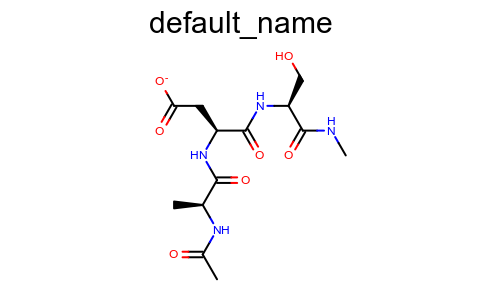

In [8]:
mol.visualize(backend='openeye')

In [9]:
omega_smarts = 'CC(=O)N[C:1][C:2](=O)[N:3][C:4]C(=O)NCC(=O)NC'
omega = mol.chemical_environment_matches(omega_smarts)
omega

[(8, 14, 16, 18)]

In [10]:
phi_smarts = 'CC(=O)NC[C:1](=O)[N:2][C:3][C:4](=O)NCC(=O)NC'
phi = mol.chemical_environment_matches(phi_smarts)
phi

[(14, 16, 18, 26)]

In [11]:
psi_smarts = 'CC(=O)NCC(=O)[N:1][C:2][C:3](=O)[N:4]CC(=O)NC'
psi = mol.chemical_environment_matches(psi_smarts)
psi

[(16, 18, 26, 28)]

In [12]:
chi1_smarts = 'CC(=O)NCC(=O)[N:1][C:2]([C:3][!#1:4])C(=O)NCC(=O)NC'
chi1 = mol.chemical_environment_matches(chi1_smarts)
chi1

[(16, 18, 20, 23)]

In [13]:
chi2_smarts = 'CC(=O)NCC(=O)N[C:1]([C:2][C:3][!#1:4])C(=O)NCC(=O)NC'
chi2 = mol.chemical_environment_matches(chi2_smarts)
chi2

[(18, 20, 23, 24)]

In [14]:
mol.atoms

[Atom(name=, atomic number=1),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=8),
 Atom(name=, atomic number=7),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=8),
 Atom(name=, atomic number=7),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=8),
 Atom(name=, atomic number=8),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=8),
 Atom(name=, atomic number=7),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=1),
 Atom(na

## Approaches

Pursuing two approaches, as separate submissions:

1. Medium priority. phi, psi, chi1 of central atom (if chi1 exists). Use strict SMARTS matching for selection of dihedral indices.

2. Low priority. All heavy torsions. We start with `mol.propers`, remove any that have H at 1 or 4 positions, remove any whose central bond not in `mol.rotatable_bonds`.

We have some options on where we get our `initial_molecules`. Should we get them:
1. **from the mol2/pdb files in the input_data.**
2. from the `dataset.json` used for the OptimizationDataset submission
3. from the public QCArchive itself

### Notes in discussion with Dave Cerutti

Choose 1 to give DC a pathway for submission.

We will want to use the dihedral freeze constraints used in the original optimization submission.
For each driven torsion, **remove** the constraint corresponding to that torsion.

We'll go up to chi2; not advised to go beyond.

Omega should be rotated +/- 20 degrees.

Let's start with three conformers for each molecule.
Still valuable to have more than one conformer per molecule.

### Notes in discussion with Josh Horton, Trevor Gokey

It turns out that ForceBalance cannot actually use constraint information on dihedrals.
Furthermore, for this reason, QCSubmit actually ignores them for TorsionDrive datasets; they only apply to Optimization datasets.

We'll ignore the constraint files for this submission.
We can revisit if new information permits or demands their use.

### Approach 1

We will do the following:

1. Pull molecules with conformers from directories similarly to how Josh Horton did this.
2. For each molecule, for each of phi, psi, omega, chi1, chi2 selection, `dataset.add_molecule` for each one, using a distinct index for each submitted `TorsionDrive`.

In [15]:
dihedrals = {'omega': omega_smarts,
             'phi': phi_smarts,
             'psi': psi_smarts,
             'chi1': chi1_smarts,
             'chi2': chi2_smarts}

In [16]:
factory = TorsiondriveDatasetFactory()

In [17]:
factory.scf_properties

['dipole', 'quadrupole', 'wiberg_lowdin_indices', 'mayer_indices']

In [18]:
dataset = factory.create_dataset(dataset_name="OpenFF Protein Fragments TorsionDrives v1.0",
                                 tagline="Torsiondrives for selected dihedrals of various protein fragments",
                                 description="Torsiondrives for selected dihedrals of various protein fragments",
                                 molecules=[])

In [19]:
dataset.metadata.long_description_url = "https://github.com/openforcefield/qca-dataset-submission/tree/master/2020-09-16-OpenFF-Protein-Fragments-TorsionDrives"

In [20]:
dataset.metadata.submitter = 'dotsdl'

In [21]:
dataset.dict()

{'qc_specifications': {'default': {'method': 'B3LYP-D3BJ',
   'basis': 'DZVP',
   'program': 'psi4',
   'spec_name': 'default',
   'spec_description': 'Standard OpenFF optimization quantum chemistry specification.',
   'store_wavefunction': 'none'}},
 'dataset_name': 'OpenFF Protein Fragments TorsionDrives v1.0',
 'dataset_tagline': 'Torsiondrives for selected dihedrals of various protein fragments',
 'dataset_type': 'TorsiondriveDataset',
 'maxiter': 200,
 'driver': <DriverEnum.gradient: 'gradient'>,
 'scf_properties': ['dipole',
  'quadrupole',
  'wiberg_lowdin_indices',
  'mayer_indices'],
 'priority': 'normal',
 'description': 'Torsiondrives for selected dihedrals of various protein fragments',
 'dataset_tags': ['openff'],
 'compute_tag': 'openff',
 'metadata': {'submitter': 'dotsdl',
  'creation_date': datetime.date(2020, 10, 8),
  'collection_type': 'TorsiondriveDataset',
  'dataset_name': 'OpenFF Protein Fragments TorsionDrives v1.0',
  'short_description': 'Torsiondrives for se

In [22]:
def populate_dataset(dataset, input_files):
    
    for folder in os.listdir(input_files):
        folder_path = os.path.join(input_files, folder)

        if not os.path.isdir(folder_path):
            print(f"Skipping {folder}")
            continue

        for combination in os.listdir(folder_path):
            combination_path = os.path.join(folder_path, combination)
            
            if not os.path.isdir(combination_path):
                print(f"Skipping {combination}")
                continue
                
            print("collecting from folder", combination_path)

            molecule = build_molecule(combination_path)
            attributes = factory.create_cmiles_metadata(molecule)

            for dihedral, dihedral_smarts in dihedrals.items():
                index = "-".join([combination.lower(), dihedral])
                print(f"...adding '{index}'")

                dihedral_indices = molecule.chemical_environment_matches(dihedral_smarts)
                
                # for omega angles only, only want to go -20 to 20 degrees from start
                if dihedral == 'omega':
                    keywords = {"dihedral_ranges": [(-20, 20)]}
                else:
                    keywords = None
                
                if len(dihedral_indices) == 0:
                    print(f"...NO DIHEDRAL INDICES FOR '{index}'")
                    continue
                
                dihedral_indices = [list(indices) for indices in dihedral_indices]

                dataset.add_molecule(index=index,
                                     molecule=molecule,
                                     dihedrals=dihedral_indices,
                                     attributes=attributes,
                                     keywords=keywords)
    return dataset

Can also check dihedrals using QCSubmit with generated PDF (be sure to generate the PDF!).
`dataset.visualize(filename)`

Might be of interest to toss in an ANI compute spec (as a separate submission); Josh is interested in running an ANI compute spec locally to see if convergence problems arise quickly.

In [23]:
ds = populate_dataset(dataset, 'Input_files/')

Skipping ._.DS_Store
collecting from folder Input_files/GLN/VAL_GLN_GLY
...adding 'val_gln_gly-omega'
...adding 'val_gln_gly-phi'
...adding 'val_gln_gly-psi'
...adding 'val_gln_gly-chi1'
...adding 'val_gln_gly-chi2'
collecting from folder Input_files/GLN/ALA_GLN_GLY
...adding 'ala_gln_gly-omega'
...adding 'ala_gln_gly-phi'
...adding 'ala_gln_gly-psi'
...adding 'ala_gln_gly-chi1'
...adding 'ala_gln_gly-chi2'
collecting from folder Input_files/GLN/GLY_GLN_SER
...adding 'gly_gln_ser-omega'
...adding 'gly_gln_ser-phi'
...adding 'gly_gln_ser-psi'
...adding 'gly_gln_ser-chi1'
...adding 'gly_gln_ser-chi2'
collecting from folder Input_files/GLN/SER_GLN_VAL
...adding 'ser_gln_val-omega'
...adding 'ser_gln_val-phi'
...adding 'ser_gln_val-psi'
...adding 'ser_gln_val-chi1'
...adding 'ser_gln_val-chi2'
collecting from folder Input_files/GLN/GLY_GLN_ALA
...adding 'gly_gln_ala-omega'
...adding 'gly_gln_ala-phi'
...adding 'gly_gln_ala-psi'
...adding 'gly_gln_ala-chi1'
...adding 'gly_gln_ala-chi2'
coll

/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C14H28N7O5 has a net charge of 1.0.
  UserWarning,


...adding 'gly_arg_ser-psi'
...adding 'gly_arg_ser-chi1'
...adding 'gly_arg_ser-chi2'
Skipping ._VAL_ARG_GLY
Skipping ._GLY_ARG_VAL
collecting from folder Input_files/ARG/GLY_ARG_GLY
...adding 'gly_arg_gly-omega'
...adding 'gly_arg_gly-phi'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C13H26N7O4 has a net charge of 1.0.
  UserWarning,


...adding 'gly_arg_gly-psi'
...adding 'gly_arg_gly-chi1'
...adding 'gly_arg_gly-chi2'
collecting from folder Input_files/ARG/SER_ARG_ALA
...adding 'ser_arg_ala-omega'
...adding 'ser_arg_ala-phi'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C15H30N7O5 has a net charge of 1.0.
  UserWarning,


...adding 'ser_arg_ala-psi'
...adding 'ser_arg_ala-chi1'
...adding 'ser_arg_ala-chi2'
Skipping ._GLY_ARG_GLY
Skipping ._ALA_ARG_GLY
collecting from folder Input_files/ARG/ALA_ARG_ALA
...adding 'ala_arg_ala-omega'
...adding 'ala_arg_ala-phi'
...adding 'ala_arg_ala-psi'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C15H30N7O4 has a net charge of 1.0.
  UserWarning,


...adding 'ala_arg_ala-chi1'
...adding 'ala_arg_ala-chi2'
Skipping ._GLY_ARG_SER
collecting from folder Input_files/ARG/VAL_ARG_VAL
...adding 'val_arg_val-omega'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C19H38N7O4 has a net charge of 1.0.
  UserWarning,


...adding 'val_arg_val-phi'
...adding 'val_arg_val-psi'
...adding 'val_arg_val-chi1'
...adding 'val_arg_val-chi2'
Skipping ._ConfARG.tar.gz
collecting from folder Input_files/ARG/SER_ARG_SER
...adding 'ser_arg_ser-omega'
...adding 'ser_arg_ser-phi'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C15H30N7O6 has a net charge of 1.0.
  UserWarning,


...adding 'ser_arg_ser-psi'
...adding 'ser_arg_ser-chi1'
...adding 'ser_arg_ser-chi2'
collecting from folder Input_files/ARG/GLY_ARG_VAL
...adding 'gly_arg_val-omega'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C16H32N7O4 has a net charge of 1.0.
  UserWarning,


...adding 'gly_arg_val-phi'
...adding 'gly_arg_val-psi'
...adding 'gly_arg_val-chi1'
...adding 'gly_arg_val-chi2'
collecting from folder Input_files/ARG/ALA_ARG_GLY
...adding 'ala_arg_gly-omega'
...adding 'ala_arg_gly-phi'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C14H28N7O4 has a net charge of 1.0.
  UserWarning,


...adding 'ala_arg_gly-psi'
...adding 'ala_arg_gly-chi1'
...adding 'ala_arg_gly-chi2'
Skipping ._VAL_ARG_VAL
Skipping ._VAL_ARG_ALA
Skipping ._GLY_ARG_ALA
Skipping ._ALA_ARG_VAL
collecting from folder Input_files/ARG/SER_ARG_VAL
Undefined stereochemistry for Input_files/ARG/SER_ARG_VAL/Conf508.mol2; skipping
...adding 'ser_arg_val-omega'
...adding 'ser_arg_val-phi'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C17H34N7O5 has a net charge of 1.0.
  UserWarning,


...adding 'ser_arg_val-psi'
...adding 'ser_arg_val-chi1'
...adding 'ser_arg_val-chi2'
collecting from folder Input_files/ARG/GLY_ARG_ALA
...adding 'gly_arg_ala-omega'
...adding 'gly_arg_ala-phi'
...adding 'gly_arg_ala-psi'
...adding 'gly_arg_ala-chi1'
...adding 'gly_arg_ala-chi2'
Skipping ._SER_ARG_SER
Skipping ConfARG.tar.gz
collecting from folder Input_files/ARG/SER_ARG_GLY
...adding 'ser_arg_gly-omega'
...adding 'ser_arg_gly-phi'
...adding 'ser_arg_gly-psi'
...adding 'ser_arg_gly-chi1'
...adding 'ser_arg_gly-chi2'
collecting from folder Input_files/ARG/ALA_ARG_SER
Undefined stereochemistry for Input_files/ARG/ALA_ARG_SER/Conf515.mol2; skipping
...adding 'ala_arg_ser-omega'
...adding 'ala_arg_ser-phi'
...adding 'ala_arg_ser-psi'
...adding 'ala_arg_ser-chi1'
...adding 'ala_arg_ser-chi2'
Skipping ._ALA_ARG_SER
Skipping ._VAL_ARG_SER
collecting from folder Input_files/ARG/ALA_ARG_VAL
...adding 'ala_arg_val-omega'
...adding 'ala_arg_val-phi'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C17H34N7O4 has a net charge of 1.0.
  UserWarning,


...adding 'ala_arg_val-psi'
...adding 'ala_arg_val-chi1'
...adding 'ala_arg_val-chi2'
collecting from folder Input_files/ARG/VAL_ARG_ALA
...adding 'val_arg_ala-omega'
...adding 'val_arg_ala-phi'
...adding 'val_arg_ala-psi'
...adding 'val_arg_ala-chi1'
...adding 'val_arg_ala-chi2'
Skipping ._ALA_ARG_ALA
collecting from folder Input_files/ARG/VAL_ARG_SER
...adding 'val_arg_ser-omega'
...adding 'val_arg_ser-phi'
...adding 'val_arg_ser-psi'
...adding 'val_arg_ser-chi1'
...adding 'val_arg_ser-chi2'
collecting from folder Input_files/ARG/VAL_ARG_GLY
...adding 'val_arg_gly-omega'
...adding 'val_arg_gly-phi'
...adding 'val_arg_gly-psi'
...adding 'val_arg_gly-chi1'
...adding 'val_arg_gly-chi2'
collecting from folder Input_files/GLU/GLY_GLU_GLY
...adding 'gly_glu_gly-omega'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C12H19N4O6 has a net charge of -1.0.
  UserWarning,


...adding 'gly_glu_gly-phi'
...adding 'gly_glu_gly-psi'
...adding 'gly_glu_gly-chi1'
...adding 'gly_glu_gly-chi2'
Skipping ._ConfGLU.tar.gz
collecting from folder Input_files/GLU/GLY_GLU_ALA
...adding 'gly_glu_ala-omega'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C13H21N4O6 has a net charge of -1.0.
  UserWarning,


...adding 'gly_glu_ala-phi'
...adding 'gly_glu_ala-psi'
...adding 'gly_glu_ala-chi1'
...adding 'gly_glu_ala-chi2'
collecting from folder Input_files/GLU/VAL_GLU_GLY
...adding 'val_glu_gly-omega'
...adding 'val_glu_gly-phi'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C15H25N4O6 has a net charge of -1.0.
  UserWarning,


...adding 'val_glu_gly-psi'
...adding 'val_glu_gly-chi1'
...adding 'val_glu_gly-chi2'
collecting from folder Input_files/GLU/VAL_GLU_ALA
Undefined stereochemistry for Input_files/GLU/VAL_GLU_ALA/Conf467.mol2; skipping
...adding 'val_glu_ala-omega'
...adding 'val_glu_ala-phi'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C16H27N4O6 has a net charge of -1.0.
  UserWarning,


...adding 'val_glu_ala-psi'
...adding 'val_glu_ala-chi1'
...adding 'val_glu_ala-chi2'
collecting from folder Input_files/GLU/GLY_GLU_VAL
Undefined stereochemistry for Input_files/GLU/GLY_GLU_VAL/Conf517.mol2; skipping
...adding 'gly_glu_val-omega'
...adding 'gly_glu_val-phi'
...adding 'gly_glu_val-psi'
...adding 'gly_glu_val-chi1'
...adding 'gly_glu_val-chi2'
collecting from folder Input_files/GLU/ALA_GLU_ALA
...adding 'ala_glu_ala-omega'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C14H23N4O6 has a net charge of -1.0.
  UserWarning,


...adding 'ala_glu_ala-phi'
...adding 'ala_glu_ala-psi'
...adding 'ala_glu_ala-chi1'
...adding 'ala_glu_ala-chi2'
collecting from folder Input_files/GLU/VAL_GLU_VAL
Undefined stereochemistry for Input_files/GLU/VAL_GLU_VAL/Conf488.mol2; skipping
...adding 'val_glu_val-omega'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C18H31N4O6 has a net charge of -1.0.
  UserWarning,


...adding 'val_glu_val-phi'
...adding 'val_glu_val-psi'
...adding 'val_glu_val-chi1'
...adding 'val_glu_val-chi2'
collecting from folder Input_files/GLU/ALA_GLU_VAL
...adding 'ala_glu_val-omega'
...adding 'ala_glu_val-phi'
...adding 'ala_glu_val-psi'
...adding 'ala_glu_val-chi1'
...adding 'ala_glu_val-chi2'
Skipping ConfGLU.tar.gz
collecting from folder Input_files/GLU/ALA_GLU_GLY
...adding 'ala_glu_gly-omega'
...adding 'ala_glu_gly-phi'
...adding 'ala_glu_gly-psi'
...adding 'ala_glu_gly-chi1'
...adding 'ala_glu_gly-chi2'
Skipping ._GLU
Skipping ConfASP.tar.gz
collecting from folder Input_files/ASP/SER_ASP_VAL
...adding 'ser_asp_val-omega'
...adding 'ser_asp_val-phi'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C15H25N4O7 has a net charge of -1.0.
  UserWarning,


...adding 'ser_asp_val-psi'
...adding 'ser_asp_val-chi1'
...adding 'ser_asp_val-chi2'
collecting from folder Input_files/ASP/VAL_ASP_VAL
...adding 'val_asp_val-omega'
...adding 'val_asp_val-phi'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C17H29N4O6 has a net charge of -1.0.
  UserWarning,


...adding 'val_asp_val-psi'
...adding 'val_asp_val-chi1'
...adding 'val_asp_val-chi2'
collecting from folder Input_files/ASP/ALA_ASP_VAL
...adding 'ala_asp_val-omega'
...adding 'ala_asp_val-phi'
...adding 'ala_asp_val-psi'
...adding 'ala_asp_val-chi1'
...adding 'ala_asp_val-chi2'
collecting from folder Input_files/ASP/VAL_ASP_ALA
...adding 'val_asp_ala-omega'
...adding 'val_asp_ala-phi'
...adding 'val_asp_ala-psi'
...adding 'val_asp_ala-chi1'
...adding 'val_asp_ala-chi2'
Skipping ._ConfASP.tar.gz
Skipping ._VAL_ASP_GLY
collecting from folder Input_files/ASP/ALA_ASP_ALA
...adding 'ala_asp_ala-omega'
...adding 'ala_asp_ala-phi'
...adding 'ala_asp_ala-psi'
...adding 'ala_asp_ala-chi1'
...adding 'ala_asp_ala-chi2'
Skipping ._GLY_ASP_ALA
collecting from folder Input_files/ASP/GLY_ASP_VAL
...adding 'gly_asp_val-omega'
...adding 'gly_asp_val-phi'
...adding 'gly_asp_val-psi'
...adding 'gly_asp_val-chi1'
...adding 'gly_asp_val-chi2'
Skipping ._SER_ASP_GLY
Skipping ._ALA_ASP_ALA
collecting from 

/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C13H21N4O7 has a net charge of -1.0.
  UserWarning,


...adding 'ser_asp_ala-psi'
...adding 'ser_asp_ala-chi1'
...adding 'ser_asp_ala-chi2'
collecting from folder Input_files/ASP/GLY_ASP_ALA
...adding 'gly_asp_ala-omega'
...adding 'gly_asp_ala-phi'
...adding 'gly_asp_ala-psi'
...adding 'gly_asp_ala-chi1'
...adding 'gly_asp_ala-chi2'
Skipping ._ALA_ASP_GLY
Skipping ._GLY_ASP_VAL
collecting from folder Input_files/ASP/GLY_ASP_GLY
...adding 'gly_asp_gly-omega'
...adding 'gly_asp_gly-phi'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C11H17N4O6 has a net charge of -1.0.
  UserWarning,


...adding 'gly_asp_gly-psi'
...adding 'gly_asp_gly-chi1'
...adding 'gly_asp_gly-chi2'
collecting from folder Input_files/ASP/SER_ASP_SER
...adding 'ser_asp_ser-omega'
...adding 'ser_asp_ser-phi'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C13H21N4O8 has a net charge of -1.0.
  UserWarning,


...adding 'ser_asp_ser-psi'
...adding 'ser_asp_ser-chi1'
...adding 'ser_asp_ser-chi2'
collecting from folder Input_files/ASP/VAL_ASP_GLY
...adding 'val_asp_gly-omega'
...adding 'val_asp_gly-phi'
...adding 'val_asp_gly-psi'
...adding 'val_asp_gly-chi1'
...adding 'val_asp_gly-chi2'
collecting from folder Input_files/ASP/GLY_ASP_SER
...adding 'gly_asp_ser-omega'
...adding 'gly_asp_ser-phi'
...adding 'gly_asp_ser-psi'


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C12H19N4O7 has a net charge of -1.0.
  UserWarning,


...adding 'gly_asp_ser-chi1'
...adding 'gly_asp_ser-chi2'
Skipping ._VAL_ASP_ALA
Skipping ._SER_ASP_ALA
collecting from folder Input_files/ASP/SER_ASP_GLY
...adding 'ser_asp_gly-omega'
...adding 'ser_asp_gly-phi'
...adding 'ser_asp_gly-psi'
...adding 'ser_asp_gly-chi1'
...adding 'ser_asp_gly-chi2'
Skipping ._ALA_ASP_SER
collecting from folder Input_files/ASP/VAL_ASP_SER
...adding 'val_asp_ser-omega'
...adding 'val_asp_ser-phi'
...adding 'val_asp_ser-psi'
...adding 'val_asp_ser-chi1'
...adding 'val_asp_ser-chi2'
collecting from folder Input_files/ASP/ALA_ASP_SER
...adding 'ala_asp_ser-omega'
...adding 'ala_asp_ser-phi'
...adding 'ala_asp_ser-psi'
...adding 'ala_asp_ser-chi1'
...adding 'ala_asp_ser-chi2'
Skipping ._HIE
Skipping ._CYS
collecting from folder Input_files/GLY/VAL_GLY_ALA
...adding 'val_gly_ala-omega'
...adding 'val_gly_ala-phi'
...adding 'val_gly_ala-psi'
...adding 'val_gly_ala-chi1'
...NO DIHEDRAL INDICES FOR 'val_gly_ala-chi1'
...adding 'val_gly_ala-chi2'
...NO DIHEDRAL IN

In [24]:
ds.visualize('torsions.pdf')

In [25]:
ds.n_records

845

In [26]:
ds.n_molecules

185

In [27]:
ds.export_dataset('dataset.json')

In [29]:
# compress dataset
! bzip2 dataset.json

In [30]:
ds.molecules_to_file('molecules.smi', 'smi')

In [31]:
# deduplicate lines in smiles file
! cat molecules.smi | uniq > molecules-dedup.smi
! mv molecules-dedup.smi molecules.smi

## Scratchpad

In [18]:
mol = build_molecule('Input_files/GLN/VAL_GLN_GLY//')

In [19]:
mol.chemical_environment_matches(omega_smarts)

[(8, 20, 22, 24)]

In [20]:
mol = build_molecule('Input_files/CYS/ALA_CYS_ALA/')

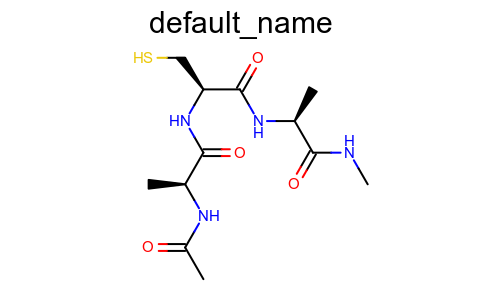

In [21]:
mol.visualize('openeye')

In [24]:
[mol.atoms[i] for i in mol.chemical_environment_matches(chi1_smarts)[0]]

[Atom(name=, atomic number=7),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=16)]

In [25]:
[mol.atoms[i] for i in mol.chemical_environment_matches(chi2_smarts)[0]]

IndexError: list index out of range

In [26]:
mol = build_molecule('Input_files/ALA/ALA_ALA_VAL/')

In [27]:
[mol.atoms[i] for i in mol.chemical_environment_matches(chi1_smarts)[0]]

IndexError: list index out of range

In [28]:
[mol.atoms[i] for i in mol.chemical_environment_matches(chi2_smarts)[0]]

IndexError: list index out of range